In [1]:
import anndata as ad
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.stats import pearsonr
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.colors as mcolors

In [3]:
fdata = ad.read_h5ad("./RNA/Multitime.annotation.h5")

In [75]:
data_list = ["./RNA/B924-1.guide.bin_20.h5", "./RNA/B926-1.guide.bin_20.h5", "./RNA/B922-1.guide.bin_20.h5",
             "./RNA/B924-2.guide.bin_20.h5", "./RNA/B926-2.guide.bin_20.h5", "./RNA/B922-2.guide.bin_20.h5"]
marker = ["1-1", "2-1", "3-1", "1-2", "2-2", "3-2"]
anndata_list = []
for idx, data in enumerate(data_list):
    anndata_ = sc.read_h5ad(data)
    anndata_.obs["marker"] = marker[idx]
    anndata_list.append(anndata_)

In [89]:
cdata = ad.concat(anndata_list, join="outer")
cdata.obs_names_make_unique()

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [91]:
cdata[:, "sgNTC"].X = cdata[:, "sgnon-targeting_1_gene"].X + cdata[:, "sgnon-targeting_2_gene"].X + cdata[:, "sgNTC"].X
cdata = cdata[:, ~cdata.var_names.str.startswith("sgnon")].copy()

In [93]:
sgs = cdata.var_names.str.split('_', n=1).str[0]
sgs_grouped = pd.DataFrame(cdata.X.toarray(), columns=cdata.var_names)
sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()
sgdata = ad.AnnData(sgs_grouped, obs=cdata.obs, var=pd.DataFrame(index=sgs_grouped.columns))
sgdata.obsm['spatial'] = cdata.obsm['spatial']
cdata = sgdata.copy()

/tmp/ipykernel_80456/1049114494.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()


In [6]:
cdata_bin100 = ad.read_h5ad("./RNA/Multitime.guide.h5")

In [94]:
cdata.var_names

Index(['sgAdrb2', 'sgAqp3', 'sgArntl', 'sgCd44', 'sgCd52', 'sgCxcl16',
       'sgDdit3', 'sgErgic2', 'sgFbxo7', 'sgFlot1', 'sgGata3', 'sgGlb1l2',
       'sgGpa33', 'sgIkbip', 'sgKcna3', 'sgKlrd1', 'sgL3mbtl3', 'sgMark3',
       'sgMcoln1', 'sgNTC', 'sgNmb', 'sgPiezo1', 'sgPomt1', 'sgPpia',
       'sgS100a11', 'sgScamp4', 'sgSlc39a8', 'sgSorl1', 'sgSrgn', 'sgTmem64',
       'sgWipf1', 'sgZc3h12a', 'sgZhx2', 'sgZscan12'],
      dtype='object')

In [7]:
def align_rna_guide_data(rnadata, guidedata, marker_name="marker"):

    rnadata.obs["cov"] = [str(marker) + '_' + str(array[0]) + "-" + str(array[1]) for marker, array in zip(rnadata.obs[marker_name], rnadata.obsm["spatial"])]
    guidedata.obs["cov"] = [str(marker) + '_' + str(array[0]) + "-" + str(array[1]) for marker, array in zip(guidedata.obs[marker_name], guidedata.obsm["spatial"])]

    guidedata.obs_names = guidedata.obs['cov']
    rnadata.obs_names = rnadata.obs['cov']
    sorted_obs_names = rnadata.obs_names.sort_values()

    common_cov = np.intersect1d(rnadata.obs['cov'], guidedata.obs['cov'])
    guidedata_filtered = guidedata[common_cov].copy()
    guidedata_filtered = guidedata_filtered[sorted_obs_names].copy()
    rnadata_reordered = rnadata[sorted_obs_names].copy()

    missing_cov = rnadata.obs['cov'][~rnadata.obs['cov'].isin(common_cov)]
    if len(missing_cov) > 0:
        missing_obs = pd.DataFrame({marker_name: [cov.split('_')[0] for cov in missing_cov]}, index=missing_cov)
        missing_obsm_spatial = np.array([[float(cov.split('_')[1].split('-')[0]), float(cov.split('_')[1].split('-')[1])] for cov in missing_cov])
        missing_X = np.zeros((len(missing_cov), guidedata.shape[1]))

        missing_guidedata = ad.AnnData(X=missing_X, obs=missing_obs, obsm={'spatial': missing_obsm_spatial})
        guidedata_filtered = guidedata_filtered.concatenate(missing_guidedata)
    return rnadata_reordered, guidedata_filtered

In [95]:
fdata, cdata = align_rna_guide_data(fdata, cdata)

In [96]:
mask = fdata.obs["annotations"].str.endswith("T")
memory_bins = fdata[mask]

In [97]:
filtered = cdata[mask][cdata[mask].X.max(axis=1) > 0]

In [98]:
filtered_guide

Index(['sgMcoln1', 'sgFlot1', 'sgGata3', 'sgScamp4', 'sgPpia', 'sgGata3',
       'sgGata3', 'sgAdrb2', 'sgFlot1', 'sgKlrd1',
       ...
       'sgDdit3', 'sgDdit3', 'sgErgic2', 'sgZc3h12a', 'sgZscan12', 'sgDdit3',
       'sgZscan12', 'sgTmem64', 'sgGlb1l2', 'sgPiezo1'],
      dtype='object', length=25781)

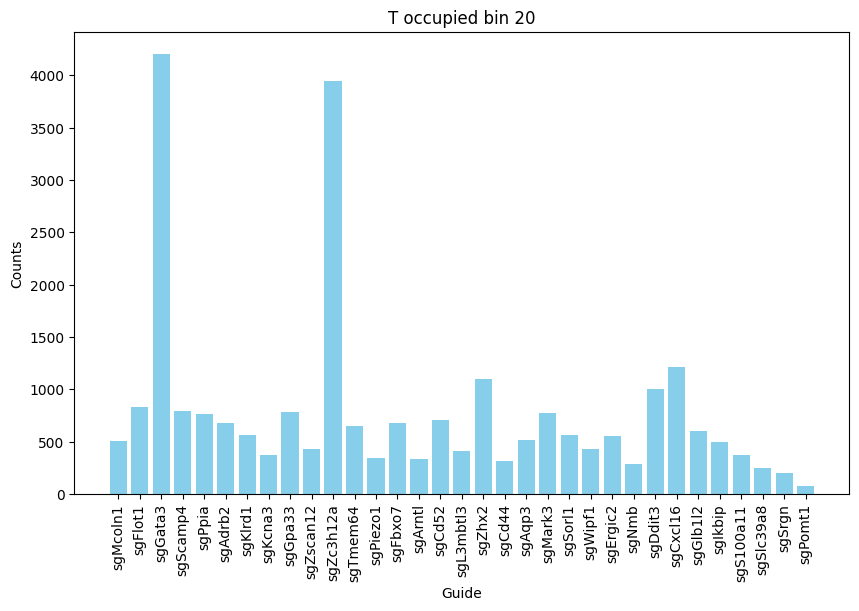

In [21]:
from collections import Counter

filtered_guide = np.array(filtered.X.argmax(axis=1).flatten())
filtered_guide = filtered.var_names[filtered_guide]

type_counts = Counter(filtered_guide)

types = list(type_counts.keys())
counts = list(type_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(types, counts, color='skyblue')
plt.xlabel('Guide')
plt.ylabel('Counts')
plt.title('T occupied bin 20')
plt.xticks(rotation=90)
plt.show()

# Guide count distribution

/tmp/ipykernel_80456/3128440637.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["value"] = np.log(filtered_data["value"])
/tmp/ipykernel_80456/3128440637.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["value"] = np.log(filtered_data["value"])
/tmp/ipykernel_80456/3128440637.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

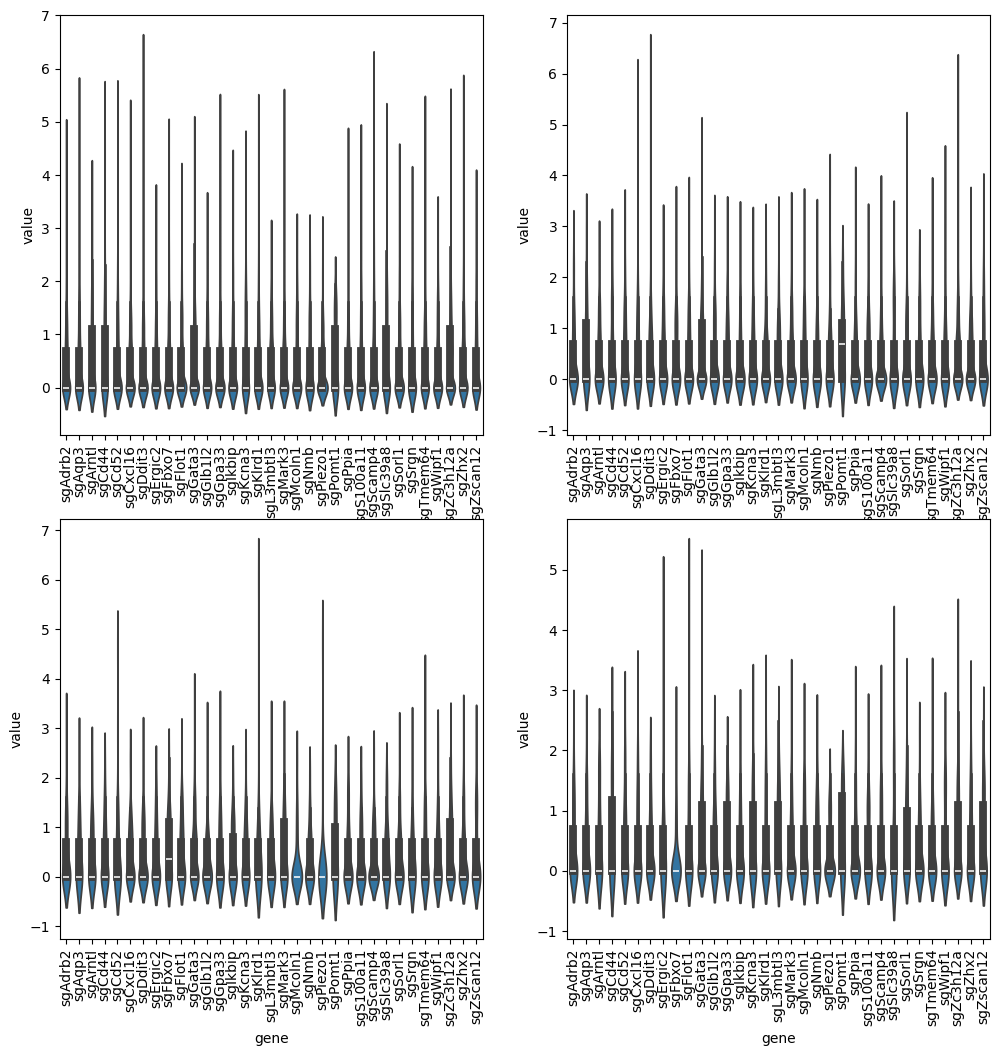

In [32]:
t_types = ["effector T", "memory T", "stem-like T", "exhausted T"]
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
for idx, t_type in enumerate(t_types):
    mask = fdata.obs["annotations"] == t_type
    guide_matrix = cdata[mask].X.toarray()

    guide_matrix = pd.DataFrame(guide_matrix, columns=cdata.var_names)

    long_format_data = guide_matrix.reset_index().melt(id_vars='index', var_name='gene', value_name='value')
    long_format_data.rename(columns={'index': 'bin'}, inplace=True)
    filtered_data = long_format_data[long_format_data['value'] > 0]
    filtered_data["value"] = np.log(filtered_data["value"])

    sns.violinplot(x='gene', y='value', data=filtered_data, ax=ax[idx // 2, idx % 2])
    ax[idx // 2, idx % 2].set_xticks(guide_matrix.columns)
    ax[idx // 2, idx % 2].set_xticklabels(guide_matrix.columns, rotation=90)
plt.show()

In [99]:
mask = np.array(fdata.obs["annotations"].str.endswith("T")) & np.array(cdata.X.max(axis=1) > 0)
t_bins = fdata[mask]

t_bins.obs["major_guide"] = np.array(cdata[mask].X.argmax(axis=1).flatten())
t_bins.obs["major_guide"] = t_bins.obs["major_guide"].apply(lambda x: cdata.var_names[x])

/tmp/ipykernel_80456/455381971.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  t_bins.obs["major_guide"] = np.array(cdata[mask].X.argmax(axis=1).flatten())


In [100]:
c_df = t_bins.obs[["major_guide", "annotations"]].groupby("major_guide").value_counts().unstack().iloc[:, :-1].T
c_df

major_guide,sgAdrb2,sgAqp3,sgArntl,sgCd44,sgCd52,sgCxcl16,sgDdit3,sgErgic2,sgFbxo7,sgFlot1,...,sgS100a11,sgScamp4,sgSlc39a8,sgSorl1,sgSrgn,sgTmem64,sgWipf1,sgZc3h12a,sgZhx2,sgZscan12
annotations,,,,,,,,,,,,,,,,,,,,,
effector T,155,108,75,81,144,256,212,114,139,175,...,77,186,62,121,44,150,87,776,207,97
stem-like T,13,4,11,9,16,27,24,13,13,15,...,8,17,7,10,5,11,7,88,8,8
memory T,40,31,42,19,45,87,81,35,39,54,...,29,54,14,43,13,45,40,215,79,27
exhausted T,21,18,9,8,30,41,28,16,24,43,...,15,31,8,21,9,24,6,151,43,17


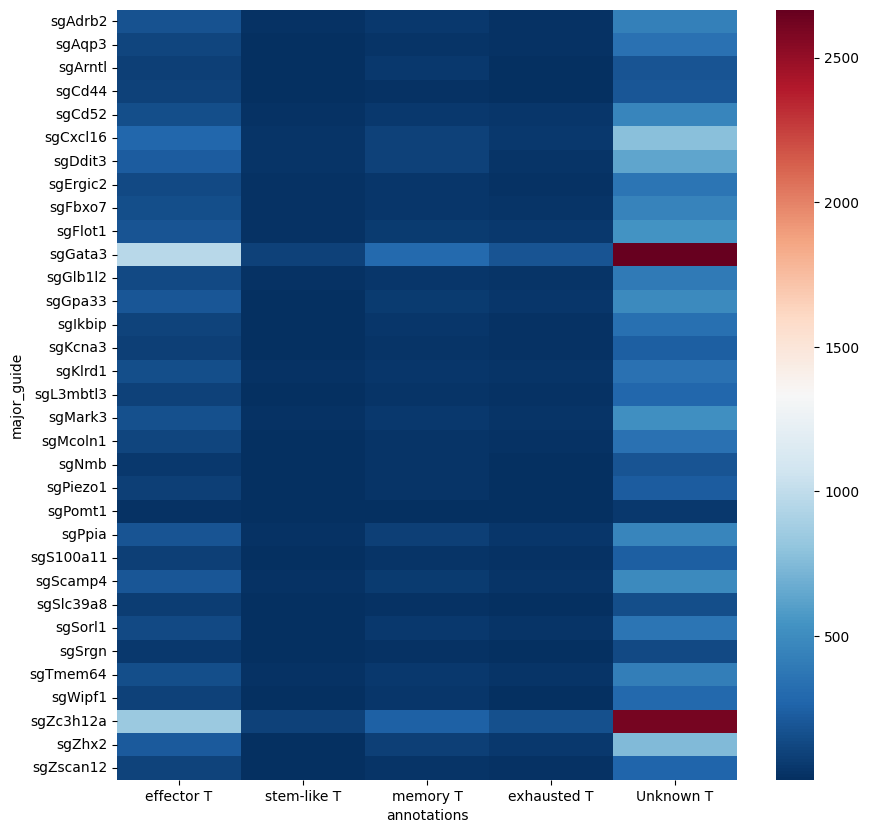

In [60]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(c_df, ax=ax, cmap="RdBu_r")
plt.show()

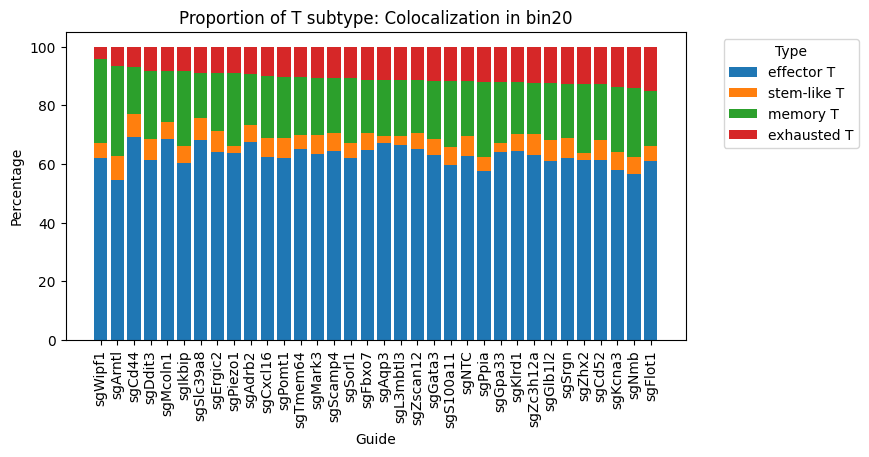

In [101]:
guide_percentage = c_df.T.div(c_df.T.sum(axis=1), axis=0) * 100
guide_percentage.sort_values(by="exhausted T", inplace=True)

plt.figure(figsize=(8, 4))

bottom = np.zeros(len(guide_percentage))

for column in guide_percentage.columns:
    plt.bar(guide_percentage.index, guide_percentage[column], bottom=bottom, label=column)
    bottom += guide_percentage[column]

plt.xlabel('Guide')
plt.ylabel('Percentage')
plt.title('Proportion of T subtype: Colocalization in bin20')
plt.xticks(rotation=90)
plt.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [9]:
long_format_data.Value.sum()

11032.0

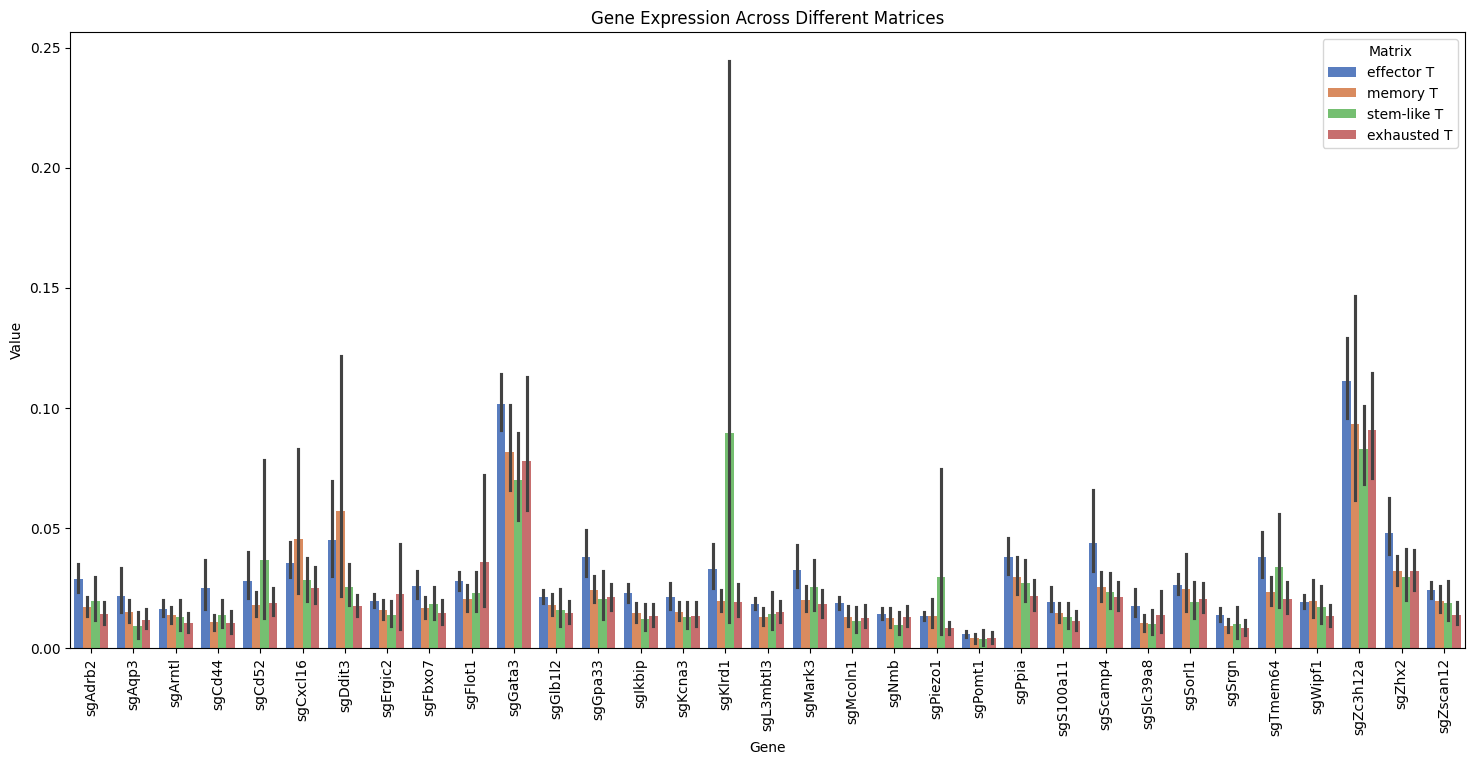

In [64]:
t_types = ["effector T", "memory T", "stem-like T", "exhausted T"]
type_matrix = {}
for t_type in t_types:
    mask = fdata.obs["annotations"] == t_type
    guide_matrix = cdata[mask].X.toarray()
    type_matrix[t_type] = pd.DataFrame(guide_matrix, columns=cdata.var_names)

combined_df = pd.concat([type_matrix[key] for key in type_matrix], axis=1, keys=t_types)
combined_df.columns = [f'{gene}_{matrix}' for matrix, gene in combined_df.columns]

long_format_data = combined_df.melt(var_name='Gene_Matrix', value_name='Value')

long_format_data['Gene'] = long_format_data['Gene_Matrix'].apply(lambda x: x.split('_')[0])
long_format_data['Matrix'] = long_format_data['Gene_Matrix'].apply(lambda x: x.split('_')[1])
long_format_data.drop(columns='Gene_Matrix', inplace=True)

plt.figure(figsize=(18, 8))
sns.barplot(x='Gene', y='Value', hue='Matrix', data=long_format_data, palette='muted')
plt.xlabel('Gene')
plt.ylabel('Value')
plt.title('Gene Expression Across Different Matrices')
plt.xticks(rotation=90)
plt.legend(title='Matrix')
plt.show()

# T cell proportion in guide major signal

In [102]:
from tqdm import tqdm

t_proportion = {}
for guide in cdata.var_names:
    guide_mask = (cdata[:, guide].X > 3)
    t_annot = fdata[guide_mask][fdata[guide_mask].obs["annotations"].str.endswith("T")].obs["annotations"]
    t_proportion[guide] = t_annot.value_counts()

In [103]:
t_proportion = pd.DataFrame(t_proportion).fillna(0).T

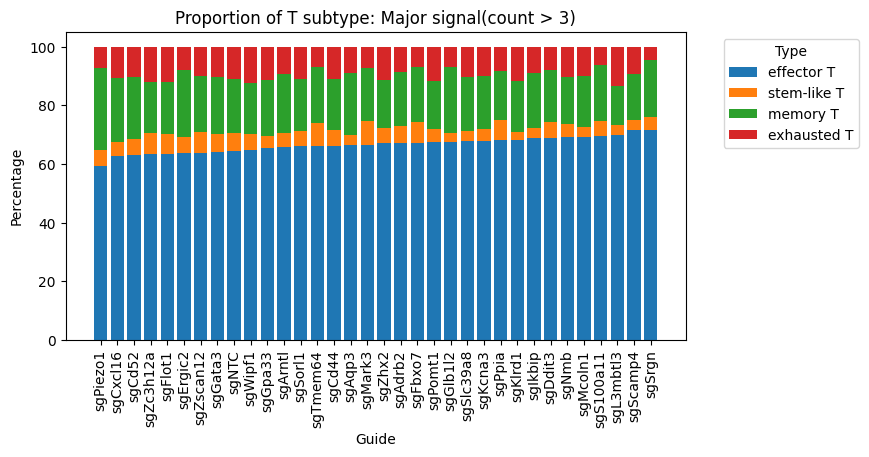

In [116]:
guide_percentage = t_proportion.iloc[:, :-1].div(t_proportion.iloc[:, :-1].sum(axis=1), axis=0) * 100
guide_percentage.sort_values(by="effector T", inplace=True)

plt.figure(figsize=(8, 4))

bottom = np.zeros(len(guide_percentage))

for column in guide_percentage.columns:
    plt.bar(guide_percentage.index, guide_percentage[column], bottom=bottom, label=column)
    bottom += guide_percentage[column]

plt.xlabel('Guide')
plt.ylabel('Percentage')
plt.title('Proportion of T subtype: Major signal(count > 3)')
plt.xticks(rotation=90)
plt.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [28]:
#fdata = ad.read_h5ad("./RNA/Multitime_sorted.h5")
bdata = ad.read_h5ad("./RNA/Multitime.fixed.guide.h5")
bdata = bdata[bdata.obs["time_point"] == "2"].copy()

In [110]:
cdata_bin100

AnnData object with n_obs × n_vars = 118279 × 67
    obs: 'marker', 'cov'
    obsm: 'spatial'

In [147]:
sgs = cdata_bin100.var_names.str.split('_', n=1).str[0]
sgs_grouped = pd.DataFrame(cdata_bin100.X.toarray(), columns=cdata_bin100.var_names)
sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()
sgdata = ad.AnnData(sgs_grouped, obs=cdata_bin100.obs, var=pd.DataFrame(index=sgs_grouped.columns))
sgdata.obsm['spatial'] = cdata_bin100.obsm['spatial']
cdata_bin100 = sgdata.copy()
cdata_bin100

/tmp/ipykernel_80456/3461522503.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()


AnnData object with n_obs × n_vars = 118279 × 34
    obs: 'marker', 'cov'
    obsm: 'spatial'

In [156]:
threshold = np.quantile(cdata_bin100.X, 0.999)
major_spac = {}
for guide in cdata_bin100.var_names:
    mask = (cdata_bin100[:, guide].X.toarray() > threshold).T[0]
    major_spac[guide] = [tuple([array[0] // 100 * 100, array[1] // 100 * 100]) for array in cdata_bin100[mask].obsm["spatial"]]

In [155]:
cdata.obs["bin"] = [tuple([array[0], array[1]]) for array in cdata.obsm["spatial"]]
cdata.obs["big_bin"] = [tuple([x // 100 * 100, y // 100 * 100]) for x, y in cdata.obs["bin"]]
cdata.obs["annotations"] = fdata.obs["annotations"]

In [150]:
guide_df = cdata.obs.iloc[[i for i, val in enumerate(cdata.obs["big_bin"]) if val in major_spac["sgGata3"]]]

In [140]:
subtype_df = guide_df.groupby("annotations", observed=True).count()["bin"]
subtype_df = subtype_df[subtype_df.index.str.endswith("T")]
subtype_df

NameError: name 'guide_df' is not defined

In [157]:
subtype_df = pd.DataFrame(index=["effector T", "stem-like T", "exhausted T", "memory T"])
for guide in tqdm(cdata.var_names):
    guide_df = cdata.obs.iloc[[i for i, val in enumerate(cdata.obs["big_bin"]) if val in major_spac[guide]]]
    t_df = guide_df.groupby("annotations", observed=True).count()["bin"]
    t_df = t_df[t_df.index.str.endswith("T")]
    t_df = pd.Series(t_df, name=guide)
    subtype_df = pd.concat([subtype_df, t_df.T], axis=1)
subtype_df.fillna(0, inplace=True)

100%|██████████| 34/34 [03:04<00:00,  5.44s/it]


In [158]:
cdata.obs

,marker,cov,bin,big_bin,annotations
cov,,,,,
1-1_10009-10009,1-1,1-1_10009-10009,"(10009, 10009)","(10000, 10000)",Macrophages
1-1_10009-10029,1-1,1-1_10009-10029,"(10009, 10029)","(10000, 10000)",Macrophages
1-1_10009-10049,1-1,1-1_10009-10049,"(10009, 10049)","(10000, 10000)",Macrophages
1-1_10009-10069,1-1,1-1_10009-10069,"(10009, 10069)","(10000, 10000)",Macrophages
1-1_10009-10089,1-1,1-1_10009-10089,"(10009, 10089)","(10000, 10000)",Macrophages
...,...,...,...,...,...
3-2_9989-9909,3-2,3-2_9989-9909,"(9989, 9909)","(9900, 9900)",Others
3-2_9989-9929,3-2,3-2_9989-9929,"(9989, 9929)","(9900, 9900)",Unknown T
3-2_9989-9949,3-2,3-2_9989-9949,"(9989, 9949)","(9900, 9900)",NK


In [159]:
subtype_df

,sgAdrb2,sgAqp3,sgArntl,sgCd44,sgCd52,sgCxcl16,sgDdit3,sgErgic2,sgFbxo7,sgFlot1,...,sgS100a11,sgScamp4,sgSlc39a8,sgSorl1,sgSrgn,sgTmem64,sgWipf1,sgZc3h12a,sgZhx2,sgZscan12
effector T,189,83,129,121,138,302,251,116,127,184,...,104,275,117,155,42,318,114,2324,401,178
stem-like T,22,6,19,11,14,38,27,11,9,15,...,9,30,11,18,3,37,14,232,44,21
exhausted T,33,19,21,21,28,61,55,24,31,44,...,14,52,17,28,6,63,16,425,75,27
memory T,77,33,51,39,51,105,89,48,37,69,...,36,100,32,52,12,111,38,812,141,65
Unknown T,517,259,339,307,390,820,677,333,343,461,...,256,669,258,412,94,756,322,5859,1057,450


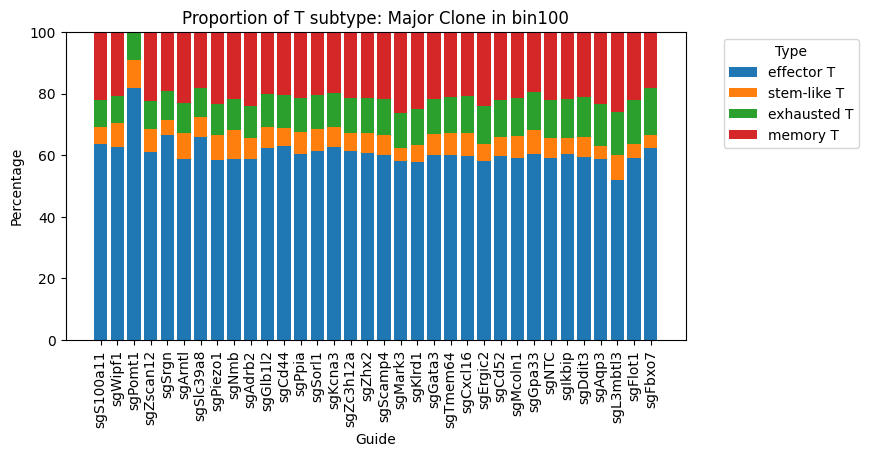

In [165]:
t_df = subtype_df.iloc[:-1].T
guide_percentage = t_df.div(t_df.sum(axis=1), axis=0) * 100
guide_percentage.sort_values(by="exhausted T", inplace=True)

plt.figure(figsize=(8, 4))

bottom = np.zeros(len(guide_percentage))

for column in guide_percentage.columns:
    plt.bar(guide_percentage.index, guide_percentage[column], bottom=bottom, label=column)
    bottom += guide_percentage[column]

plt.xlabel('Guide')
plt.ylabel('Percentage')
plt.title('Proportion of T subtype: Major Clone in bin100')
plt.xticks(rotation=90)
plt.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_u

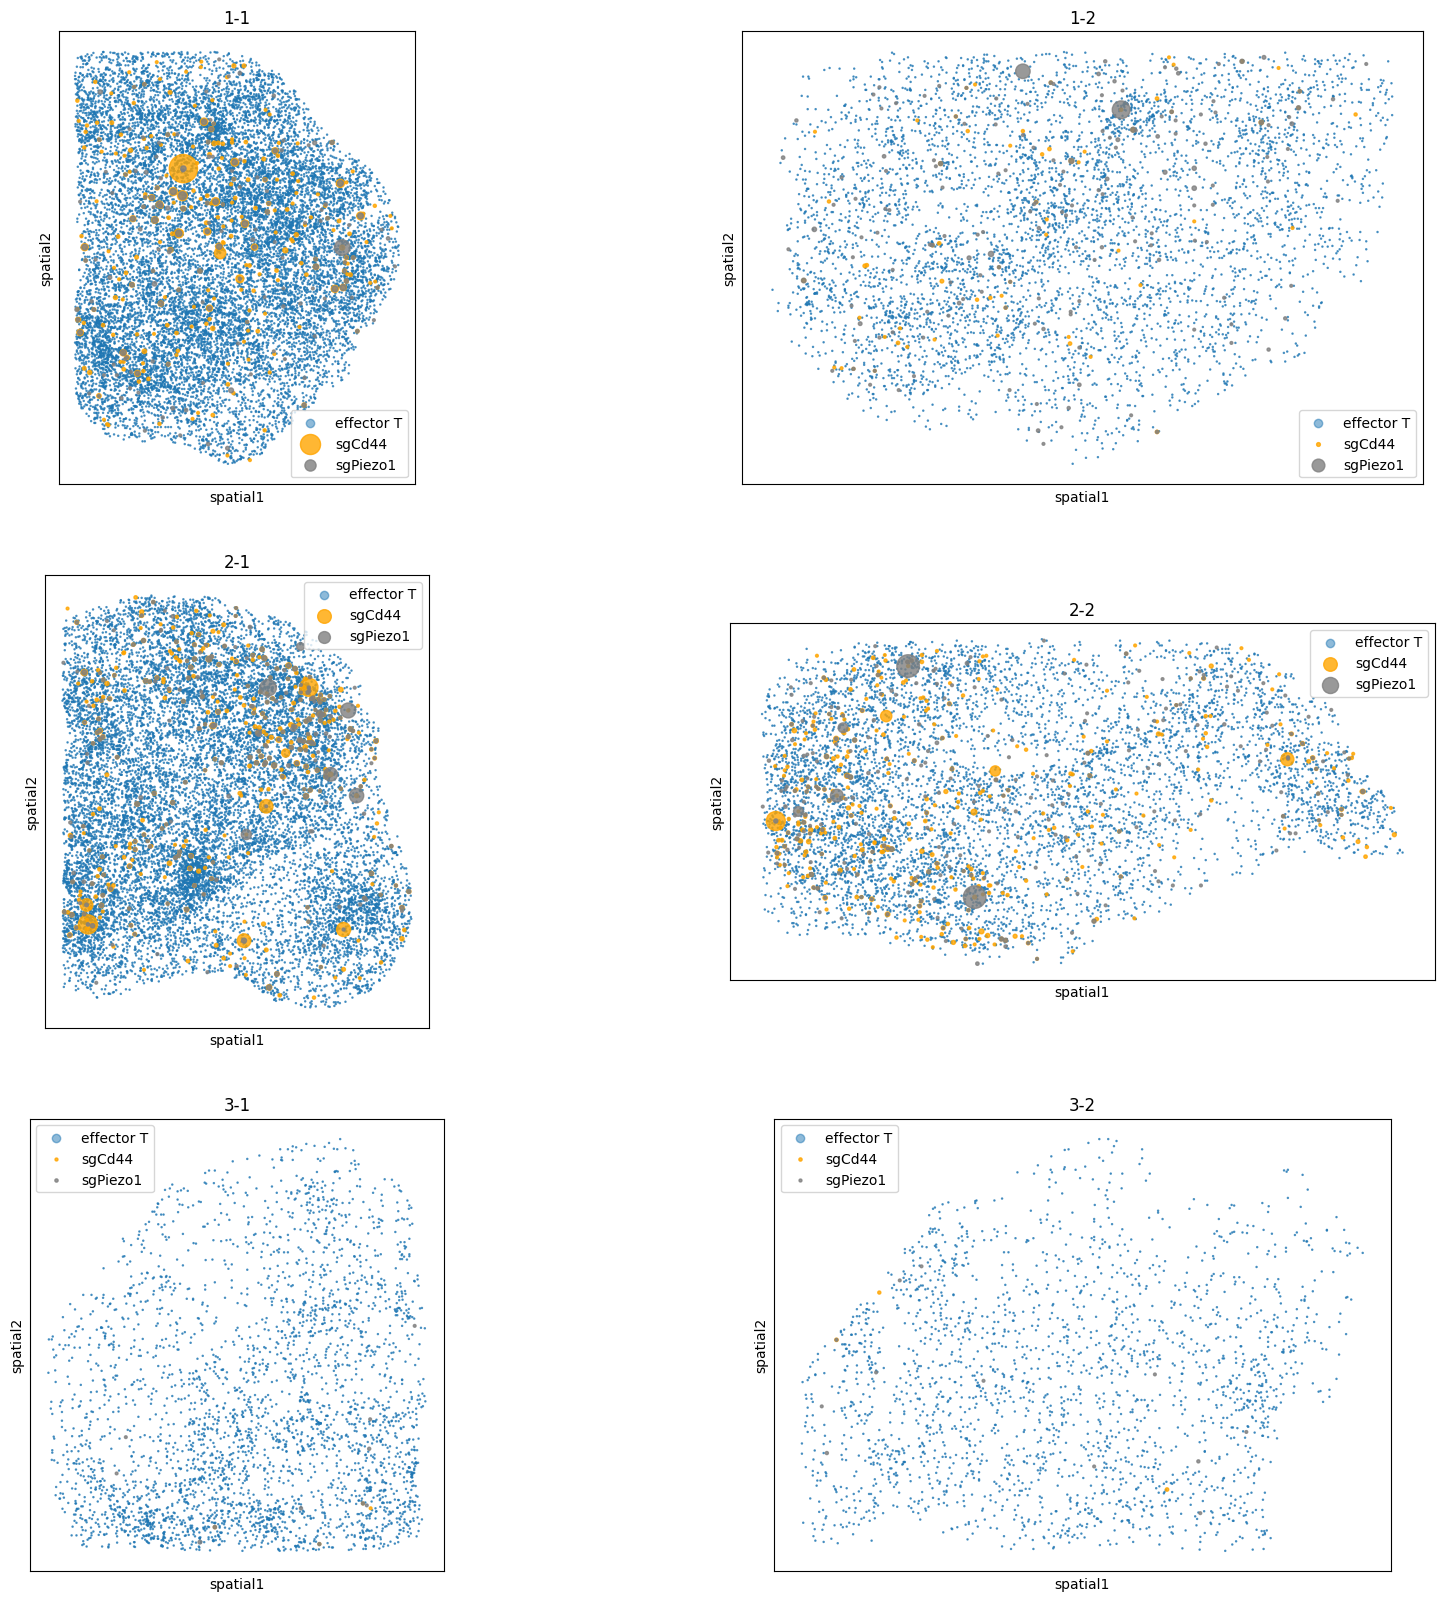

In [138]:
fig, axs = plt.subplots(3, 2, figsize=(20, 20))
for idx, marker in enumerate(np.unique(fdata.obs["marker"])): 
    ax = axs[idx // 2, idx % 2]
    sq.pl.spatial_scatter(fdata[(fdata.obs["annotations"] == "effector T") & (fdata.obs["marker"] == marker)], color="annotations", size=2, alpha=0.5, shape=None, library_key="marker", ax=ax)
    
    cdata_ = cdata[cdata.obs["marker"] == marker]
    mask = (cdata_[:, "sgCd44"].X > 3)
    x = cdata_[mask].obsm["spatial"][:, 0]
    y = cdata_[mask].obsm["spatial"][:, 1]
    a = (cdata_[mask, "sgCd44"].X.toarray().flatten()).tolist()
    ax.scatter(x, y, s=a, alpha=0.8, color="Orange", label="sgCd44")
    
    mask = (cdata_[:, "sgPiezo1"].X > 3)
    x = cdata_[mask].obsm["spatial"][:, 0]
    y = cdata_[mask].obsm["spatial"][:, 1]
    a = (cdata_[mask, "sgPiezo1"].X.toarray().flatten()).tolist()
    ax.scatter(x, y, s=a, alpha=0.8, color="Grey", label="sgPiezo1")
    ax.set_title(marker)
    ax.legend()
plt.show()

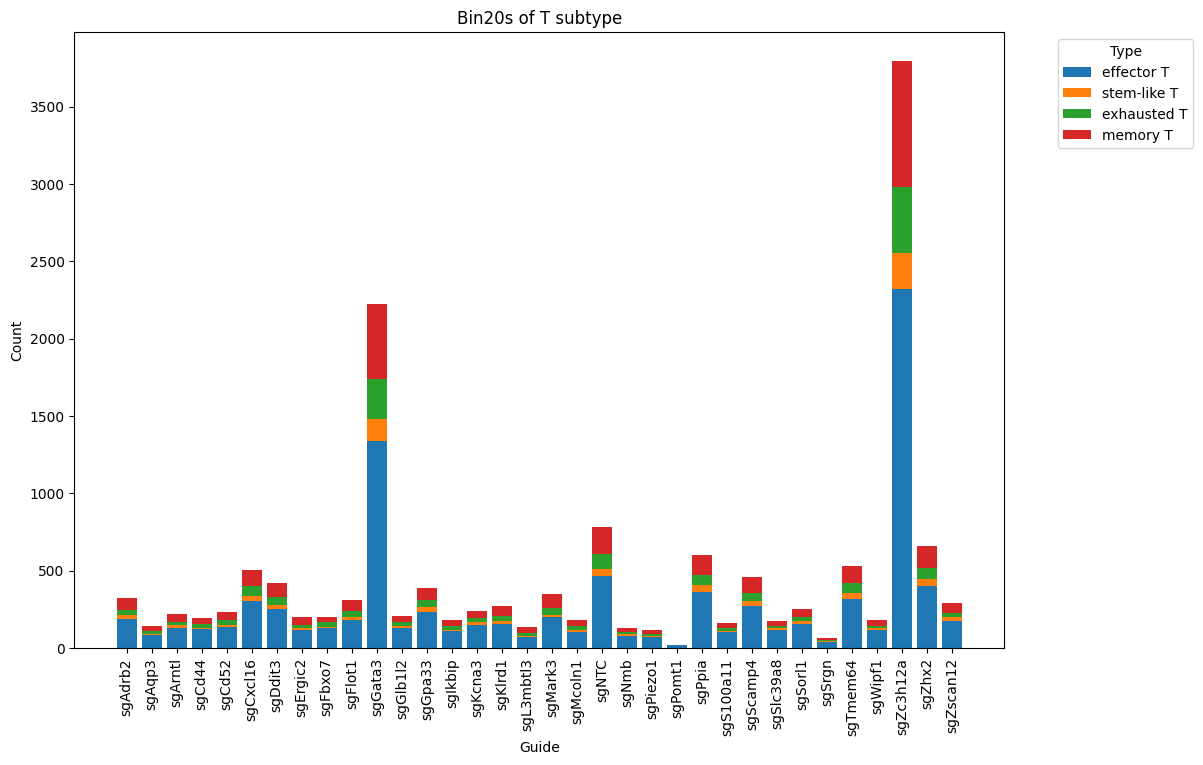

In [162]:
t_df = subtype_df.iloc[:-1].T

plt.figure(figsize=(12, 8))

bottom = np.zeros(len(t_df))

for column in t_df.columns:
    plt.bar(t_df.index, t_df[column], bottom=bottom, label=column)
    bottom += t_df[column]

plt.xlabel('Guide')
plt.ylabel('Count')
plt.title('Bin20s of T subtype')
plt.xticks(rotation=90)
plt.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()